<a href="https://colab.research.google.com/github/szymonszczurowski/Sentiment-Analysis-of-YouTube-Comments/blob/main/Best_model_for_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selecting the best model for sentiment classification

## 1.0.0 Importing Libraries and Packages

In [1]:
!pip3 install emoji==1.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.0/170.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169295 sha256=556f0f7e69e8e1fdc839e0da5e2dccdca5cdbe2085909c15604d3a8df9cf0ff3
  Stored in directory: /root/.cache/pip/wheels/3d/c9/af/02caa5725634f27f4e2e43852f67fc9069d014038b236a827e
Successfully built emoji


In [2]:
!pip install transformers

In [3]:
!pip install pysentimiento

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00


In [4]:
!pip install monkeylearn

In [5]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from transformers import pipeline, AutoTokenizer, BertTokenizer, BertForSequenceClassification
from pysentimiento import create_analyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

## 2.0.0 Data preparation

### 2.0.1 Loading a list of comments

In [8]:
with open('comments_list.pkl', 'rb') as file:
    comments = pickle.load(file)

print(comments)

['<a href="https://www.youtube.com/watch?v=TVQgSIlN4no&amp;t=2m26s">2:26</a> duke moment', 'perfect timing on an american test and an alpha kitten bullieing a runt,....', 'Kevin is my spirit animal', 'The only antidepressant ill ever need is the office…', 'How to pick up chicks<br>1. Grow a mustache<br>2. Say &quot;Smile if you love mens prostates&quot;', 'somethin about <br>&quot;the devil you know&quot;', 'the scene with who and whom at <a href="https://www.youtube.com/watch?v=TVQgSIlN4no&amp;t=5m09s">5:09</a> was a masterpiece', 'Its always Creed 😂 he&#39;s one of my favorites', 'Michael declaring bankruptcy always kills me🤣', 'that SOUP skit is HILARIOUS as hell', 'Bro <a href="https://www.youtube.com/watch?v=TVQgSIlN4no&amp;t=1m28s">1:28</a> still makes me die to this very day lmaooo', 'It is really weak compared to UK', 'The bankruptcy part might be my favorite 😂😂😂', 'For an &quot;office moments that make me laugh lime an idiot&quot; this video is really short!', 'The “gets me ev

### 2.0.2 Label loading

In [9]:
data_1 = pd.read_csv('Comment classification-1.csv', header=None, names=['Komentarz', 'Klasyfikacja'])
data_1

,Komentarz,Klasyfikacja
0,"<a href=""https://www.youtube.com/watch?v=TVQgS...",0
1,perfect timing on an american test and an alph...,0
2,Kevin is my spirit animal,0
3,The only antidepressant ill ever need is the o...,0
4,How to pick up chicks<br>1. Grow a mustache<br...,0
...,...,...
95,Also Dwight actually rocks that pumpkin head t...,0
96,Michael hitting Meredith with the car actually...,1
97,"Believe me, when its with context its even mor...",0
98,... I dont even know where to start... I am no...,-1


In [10]:
data_2 = pd.read_csv('Comment classification-2.csv', header=None, names=['Komentarz', 'Klasyfikacja'])
data_2

,Komentarz,Klasyfikacja
0,"<a href=""https://www.youtube.com/watch?v=TVQgS...",0
1,perfect timing on an american test and an alph...,1
2,Kevin is my spirit animal,1
3,The only antidepressant ill ever need is the o...,1
4,How to pick up chicks<br>1. Grow a mustache<br...,0
...,...,...
95,Also Dwight actually rocks that pumpkin head t...,1
96,Michael hitting Meredith with the car actually...,1
97,"Believe me, when its with context its even mor...",1
98,... I dont even know where to start... I am no...,-1


In [11]:
labels_1 = data_1['Klasyfikacja'].tolist()
print(labels_1)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, -1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, -1, 0, 0, 0, 1, 1, 1, 0, 0, -1, 0, -1, 0, 0, 0, 0, -1, 0, -1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0]


In [12]:
labels_2 = data_2['Klasyfikacja'].tolist()
print(labels_2)

[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, -1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 0, 1, 1, 1, 1, -1, 1, -1, 0, -1, 1, 1, 0, 1, -1, 1, -1, 1, 0, 0, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1]


## 3.0.0 Downloading models from huggingface

### 3.0.1 ProsusAI/finbert

In [13]:
finbert = pipeline("text-classification", model = "ProsusAI/finbert")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
finbert('I love you')

[{'label': 'neutral', 'score': 0.8632259368896484}]

### 3.0.2 lxyuan/distilbert-base-multilingual-cased-sentiments-student

In [15]:
distilled_student_sentiment_classifier = pipeline("text-classification", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [16]:
distilled_student_sentiment_classifier('I love you')

[{'label': 'positive', 'score': 0.969622790813446}]

### 3.0.3 finiteautomata/bertweet-base-sentiment-analysis

In [17]:
bertweet_base_sentiment_analysis = pipeline("text-classification", model = "finiteautomata/bertweet-base-sentiment-analysis")

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [18]:
bertweet_base_sentiment_analysis('I love you')

[{'label': 'POS', 'score': 0.9916695356369019}]

### 3.0.4 ahmedrachid/FinancialBERT-Sentiment-Analysis

In [19]:
financia_BERT_sentiment_analysis =  pipeline("text-classification", model = "ahmedrachid/FinancialBERT-Sentiment-Analysis")

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/464k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
financia_BERT_sentiment_analysis('I love you')

[{'label': 'neutral', 'score': 0.9955909252166748}]

## 4.0.0 Evaluation of models

In [21]:
def metrics(labels, scores):
  accuracy = accuracy_score(labels, sentiment_scores)
  precision = precision_score(labels, sentiment_scores, average='weighted', zero_division=1)
  recall = recall_score(labels, sentiment_scores, average='weighted', zero_division=1)
  f1 = f1_score(labels, sentiment_scores, average='weighted', zero_division=1)
  conf_matrix = confusion_matrix(labels, sentiment_scores)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

In [22]:
def matrix_confusion(labels, scores):
  conf_matrix = confusion_matrix(labels, sentiment_scores)
  classes = ["Negative", "Neutral", "Positive"]

  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
  disp.plot(cmap='Blues', values_format='d')
  confusion_matrix(labels, sentiment_scores)

### 4.1.0 ProsusAI/finbert

#### 4.1.1 Conducting sentiment classifications

In [23]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [24]:
sentiment_scores = []
labels_finbert_1 = labels_1.copy()
labels_finbert_2 = labels_2.copy()

for comment in comments:
    tokens = tokenizer.encode(comment, add_special_tokens=True)
    if len(tokens) < 512:
        result = finbert(comment)
        label = result[0]['label']

        if label == 'negative':
            score = -1
        elif label == 'neutral':
            score = 0
        elif label == 'positive':
            score = 1
        else:
            score = None

        sentiment_scores.append(score)
    else:
        index_to_remove = comments.index(comment)
        del labels_finbert_1[index_to_remove]
        del labels_finbert_2[index_to_remove]


#### 4.1.2 Metrics - label set number 1

In [25]:
metrics(labels_finbert_1, sentiment_scores)

Accuracy: 0.73
Precision: 0.7686108273748722
Recall: 0.73
F1 Score: 0.6812335329341317


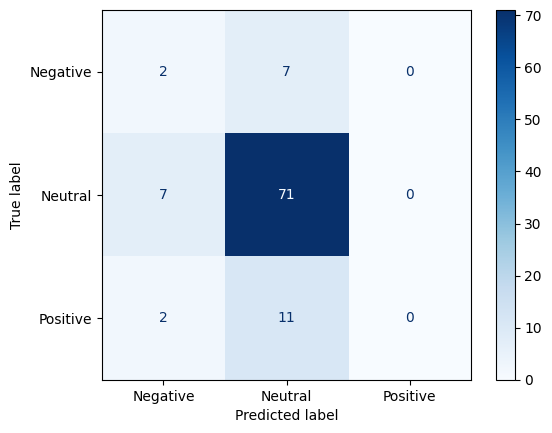

In [26]:
matrix_confusion(labels_finbert_1, sentiment_scores)

#### 4.1.3 Metrics - label set number 2

In [27]:
metrics(labels_finbert_2, sentiment_scores)

Accuracy: 0.42
Precision: 0.6323493360572012
Recall: 0.42
F1 Score: 0.28430976430976423


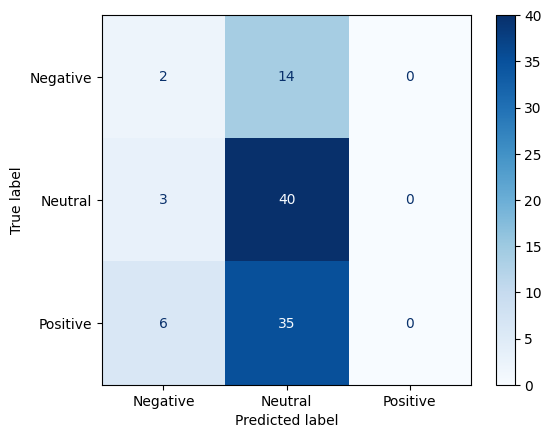

In [28]:
matrix_confusion(labels_finbert_2, sentiment_scores)

### 4.2.0 lxyuan

#### 4.2.1 Conducting sentiment classifications

In [29]:
sentiment_scores = []

for comment in comments:
      result = distilled_student_sentiment_classifier(comment)

      label = result[0]['label']

      if label == 'negative':
          score = -1
      elif label == 'neutral':
          score = 0
      elif label == 'positive':
          score = 1
      else:
          score = None

      sentiment_scores.append(score)




#### 4.2.2 Metrics - label set number 1

In [30]:
metrics(labels_1, sentiment_scores)

Accuracy: 0.17
Precision: 0.42619450317124735
Recall: 0.17
F1 Score: 0.07850452488687784


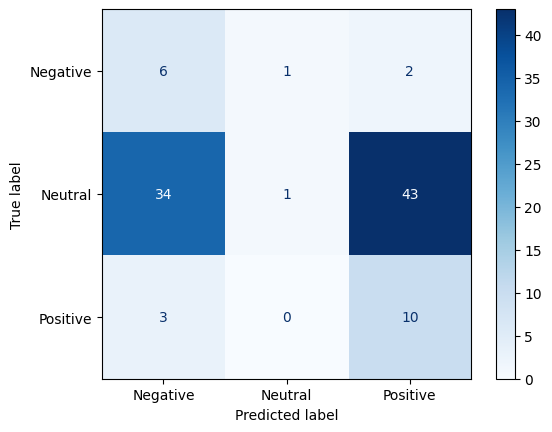

In [31]:
matrix_confusion(labels_1, sentiment_scores)

#### 4.2.3 Metrics - label set number 2

In [32]:
metrics(labels_2, sentiment_scores)

Accuracy: 0.35
Precision: 0.43485200845665956
Recall: 0.35
F1 Score: 0.28146633709981167


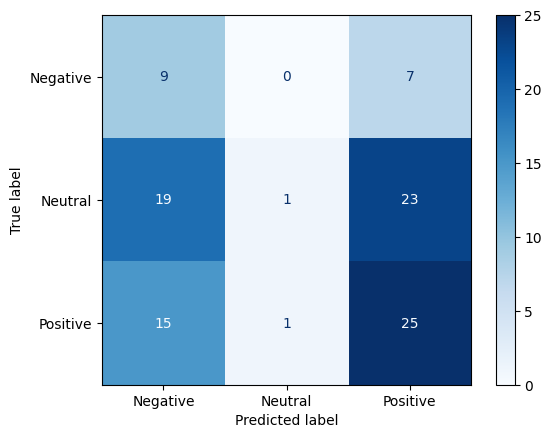

In [33]:
matrix_confusion(labels_2, sentiment_scores)

### 4.3.0 finiteautomata

#### 4.3.1 Conducting sentiment classifications

In [34]:
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

In [35]:
sentiment_scores = []
labels_finiteautomata_1 = labels_1.copy()
labels_finiteautomata_2 = labels_2.copy()

for comment in comments:
    tokens = tokenizer.encode(comment, add_special_tokens=True)
    if len(tokens) < 100:
        result = bertweet_base_sentiment_analysis(comment)
        label = result[0]['label']

        score = {'NEG': -1, 'NEU': 0, 'POS': 1}.get(label)

        if score is not None:
            sentiment_scores.append(score)
            labels_finiteautomata_1.append(labels_finiteautomata_1[-1])
            labels_finiteautomata_2.append(labels_finiteautomata_2[-1])

labels_finiteautomata_1 = labels_finiteautomata_1[:len(sentiment_scores)]
labels_finiteautomata_2 = labels_finiteautomata_2[:len(sentiment_scores)]


#### 4.3.2 Metrics - label set number 1


In [36]:
metrics(labels_finiteautomata_1, sentiment_scores)

Accuracy: 0.6868686868686869
Precision: 0.8433775572813006
Recall: 0.6868686868686869
F1 Score: 0.7218930375180376


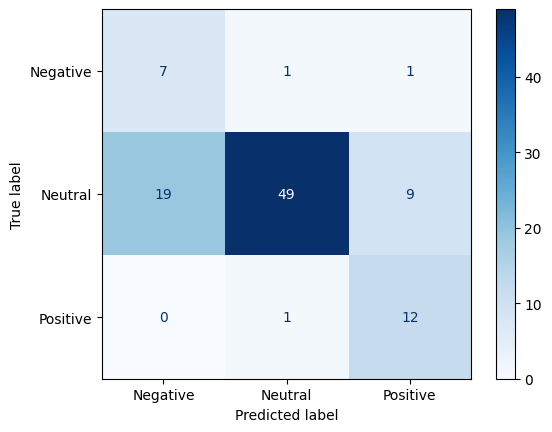

In [37]:
matrix_confusion(labels_finiteautomata_1, sentiment_scores)

#### 4.3.3 Metrics - label set number 2

In [38]:
metrics(labels_finiteautomata_2, sentiment_scores)

Accuracy: 0.5454545454545454
Precision: 0.6135217525591857
Recall: 0.5454545454545454
F1 Score: 0.5542284300005644


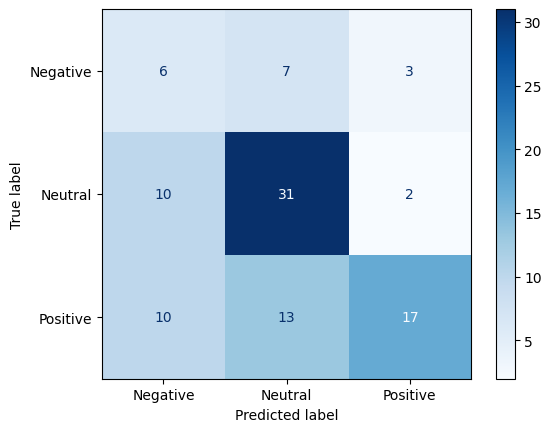

In [39]:
matrix_confusion(labels_finiteautomata_2, sentiment_scores)

### 4.4.0 ahmedrachid

### 4.4.1 Conducting sentiment classifications


In [40]:
sentiment_scores = []

for comment in comments:
      result = financia_BERT_sentiment_analysis(comment)
      label = result[0]['label']

      if label == 'negative':
          score = -1
      elif label == 'neutral':
          score = 0
      elif label == 'positive':
          score = 1
      else:
          score = None

      sentiment_scores.append(score)




#### 4.4.2 Metrics - label set number 1


In [41]:
metrics(labels_1, sentiment_scores)

Accuracy: 0.77
Precision: 0.7682894736842105
Recall: 0.77
F1 Score: 0.7087181604522645


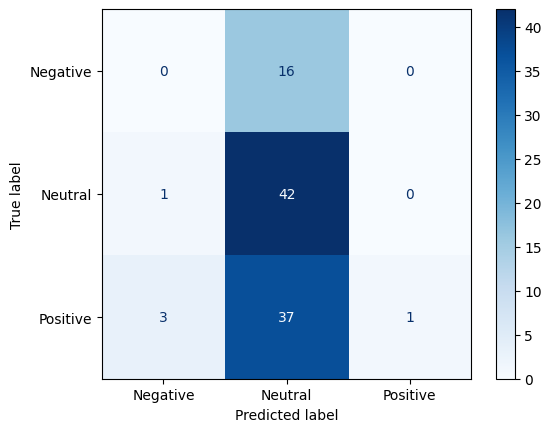

In [42]:
matrix_confusion(labels_2, sentiment_scores)

#### 4.4.3 Metrics - label set number 2

In [43]:
metrics(labels_2, sentiment_scores)

Accuracy: 0.43
Precision: 0.6001052631578948
Recall: 0.43
F1 Score: 0.2812629399585921


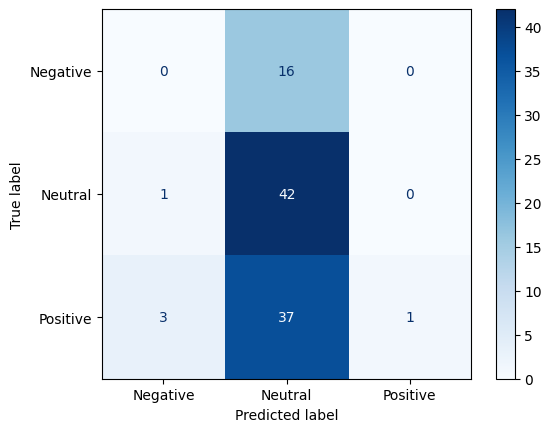

In [44]:
matrix_confusion(labels_2, sentiment_scores)